# segmentation with SVM

In [1]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
# import mahotas as mt

ModuleNotFoundError: No module named 'mahotas'

uint8
(256, 256)
0
54.03192138671875
42.61591772076806


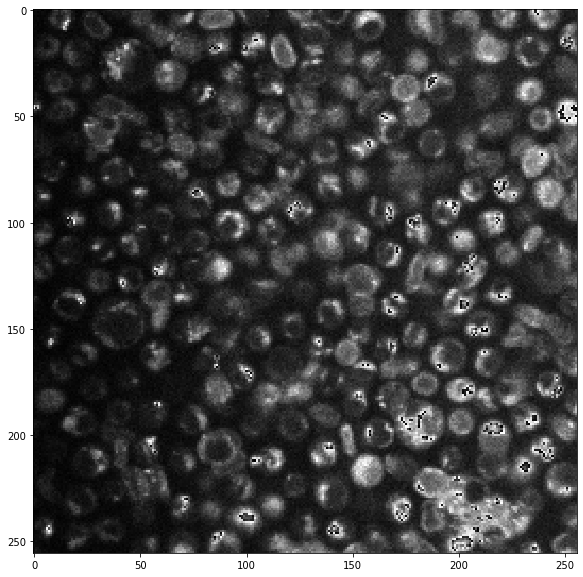

In [17]:
Image_dir = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0'
Mask_dir = os.path.join(Image_dir,'Masks')
Image_name = 'Tcells_Th0_1f_photons.tiff'

I = imageio.imread(os.path.join(Image_dir,Image_name)).astype("uint8")
if len(I.shape) > 2:
    I = I[:,:,0]
print(I.dtype)
print(I.shape)

print(I.min())
print(I.mean())
print(I.std())

# print images
plt.figure(figsize=(10,10))
plt.imshow(I, cmap='gray', vmin=0, vmax=255)

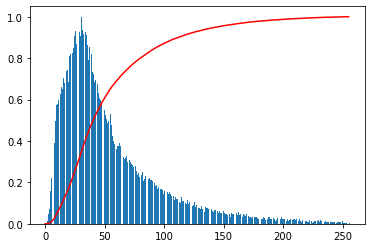

In [18]:
hist, bins = np.histogram(I, bins=256, range=[0,256])
cum_hist = np.cumsum(hist)

height, width = I.shape
norm_cum_hist = cum_hist / (height * width)
norm_hist = hist / hist.max()

#width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, norm_hist, align='center')
plt.plot(norm_cum_hist, color='r')
plt.show()

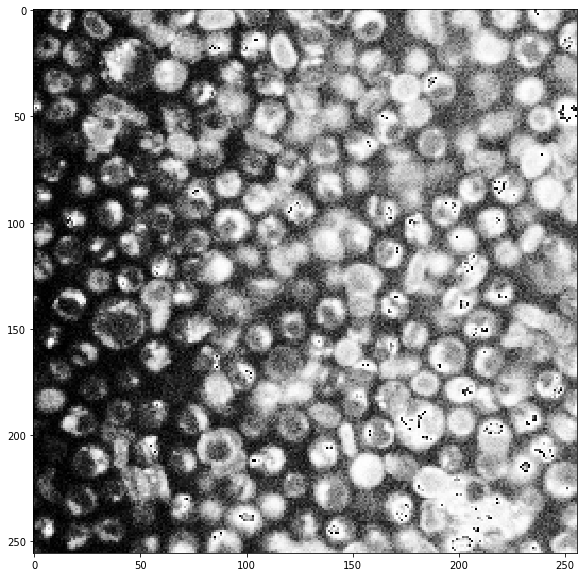

In [25]:
hists_cdf = (norm_cum_hist * 255).astype("uint8")

# mapping
img_eq = hists_cdf[I]
# img_eq[img_eq<100] = 0
plt.figure(figsize=(10,10))
plt.imshow(img_eq, cmap='gray')

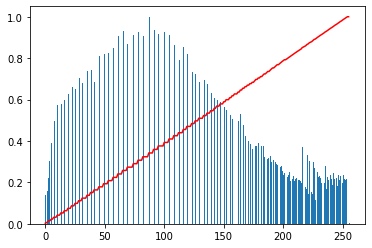

In [13]:
hist, bins = np.histogram(img_eq, bins=256, range=[0,256])
cum_hist = np.cumsum(hist)

height, width = img_eq.shape
norm_cum_hist = cum_hist / (height * width)
norm_hist = hist / hist.max()

#width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, norm_hist, align='center')
plt.plot(norm_cum_hist, color='r')
plt.show()

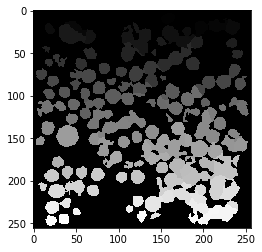

In [6]:
M_cell = 'Tcells_Th0_1n_photons_cells.tiff'
Mask_cell = imageio.imread(os.path.join(Mask_dir,M_cell))
plt.imshow(Mask_cell, cmap='gray', vmin=0, vmax=255)
print(Mask_cell.shape)

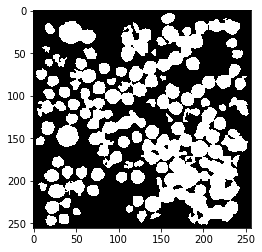

In [23]:
Mask_cell[Mask_cell>=1] = 1
plt.imshow(Mask_cell, cmap='gray', vmin=0, vmax=1)

In [24]:
print(Mask_cell.max(), Mask_cell.shape)

1 (256, 256)


In [27]:
x = img_eq.reshape(-1,1)
x.shape

(65536, 1)

## cell segmentation

In [17]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
    plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
    return img_eq
#     vec_img_eq = img_eq.reshape(-1,1)
#     return vec_img_eq

In [18]:
def label_preprocess(mask_dir):
    mask = imageio.imread(mask_dir).astype('uint8')
    mask[mask>=1] = 1
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    return mask
#     vec_mask = mask.reshape(-1,1)
#     return vec_mask

In [19]:
img_dir = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.tiff'
lab_dir = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Masks/Tcells_Th0_1n_photons_cells.tiff'

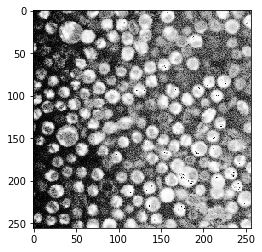

In [20]:
img_pre = img_preprocess(img_dir)

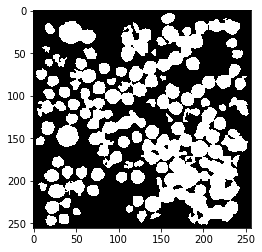

In [21]:
mask_pre = label_preprocess(lab_dir)


In [ ]:
def harlick_features(img, h_neigh, ss_idx):
    print ('[INFO] Computing haralick features.')
    size = h_neigh
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = patches.reshape(-1, size, size)

    if len(ss_idx) == 0 :
        bar = progressbar.ProgressBar(maxval=len(patches), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    else:
        bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()

    h_features = []

    if len(ss_idx) == 0:
        for i, p in enumerate(patches):
            bar.update(i+1)
            h_features.append(calc_haralick(p))
    else:
        for i, p in enumerate(patches[ss_idx]):
            bar.update(i+1)
            h_features.append(calc_haralick(p))
    #h_features = [calc_haralick(p) for p in patches[ss_idx]]
    return np.array(h_features)

In [ ]:
def create_binary_pattern(img, p, r):
    print ('[INFO] Computing local binary pattern features.')
    lbp = feature.local_binary_pattern(img, p, r)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255

In [ ]:
def create_features(img, img_gray, label, train=True):
    lbp_radius = 24 # local binary pattern neighbourhood
    h_neigh = 11 # haralick neighbourhood
    num_examples = 1000 # number of examples per image to use for training model

    lbp_points = lbp_radius*8
    h_ind = int((h_neigh - 1)/ 2)

    feature_img = np.zeros((img.shape[0],img.shape[1],4))
    feature_img[:,:,:3] = img
    img = None
    feature_img[:,:,3] = create_binary_pattern(img_gray, lbp_points, lbp_radius)
    feature_img = feature_img[h_ind:-h_ind, h_ind:-h_ind]
    features = feature_img.reshape(feature_img.shape[0]*feature_img.shape[1], feature_img.shape[2])

    if train == True:
        ss_idx = subsample_idx(0, features.shape[0], num_examples)
        features = features[ss_idx]
    else:
        ss_idx = []

    h_features = harlick_features(img_gray, h_neigh, ss_idx)
    features = np.hstack((features, h_features))

    if train == True:

        label = label[h_ind:-h_ind, h_ind:-h_ind]
        labels = label.reshape(label.shape[0]*label.shape[1], 1)
        labels = labels[ss_idx]
    else:
        labels = None

    return features, labels

In [ ]:
def create_training_dataset(image_list, label_list):
    print ('[INFO] Creating training dataset on %d image(s).' %len(image_list))
    X = []
    y = []

    for i, img_dir in enumerate(image_list):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, labels = create_features(img, img_gray, label_list[i])
        X.append(features)
        y.append(labels)

    X = np.array(X)
    X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    y = np.array(y)
    y = y.reshape(y.shape[0]*y.shape[1], y.shape[2]).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print ('[INFO] Feature vector size:', X_train.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
def train_model(X, y, classifier):
    if classifier == "SVM":
        from sklearn.svm import SVC
        print ('[INFO] Training Support Vector Machine model.')
        model = SVC()
        model.fit(X, y)
    elif classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        print ('[INFO] Training Random Forest model.')
        model = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=42)
        model.fit(X, y)
    elif classifier == "GBC":
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
        model.fit(X, y)

In [ ]:
def test_model(X, y, model):
    pred = model.predict(X)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(y, pred)

    print ('--------------------------------')
    print ('[RESULTS] Accuracy: %.2f' %accuracy)
    print ('[RESULTS] Precision: %.2f' %precision)
    print ('[RESULTS] Recall: %.2f' %recall)
    print ('[RESULTS] F1: %.2f' %f1)
    print ('--------------------------------')

In [ ]:
all_dir = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells'
image_list, label_list = read_data(all_dir)

X_train, X_test, y_train, y_test = create_training_dataset(image_list, label_list)
model = train_model(X_train, y_train, classifier)
test_model(X_test, y_test, model)


In [67]:
image_list = []
label_list = []

all_dir = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells'
all_folder = os.listdir(all_dir)
for folder in all_folder:
# folder = all_folder[3]
    current_folder = os.path.join(all_dir, folder)
    all_images = os.listdir(current_folder)
    for file_name in all_images:
        # file_name = all_images[3]
        file_name_front, file_name_end = os.path.splitext(file_name)
        if file_name_end is not '':
            fn = file_name_front.split('_')[2][1]

            if file_name_end=='.tiff' and fn=='n':
                image_dir = os.path.join(current_folder,file_name)
                image_list.append(image_dir)

                mask_dir = os.path.join(current_folder,'Masks',file_name_front+'cells.tiff')
                label_list.append(mask_dir)

In [68]:
image_list

['/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Tcells_Th2_2n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Tcells_Th2_1n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Tcells_Th2_4n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Tcells_Th2_3n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Tcells_Th1_4n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Tcells_Th1_1n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Tcells_Th1_3n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Tcells_Th1_2n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_2n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_5n_photons.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells

In [69]:
label_list

['/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Masks/Tcells_Th2_2n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Masks/Tcells_Th2_1n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Masks/Tcells_Th2_4n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th2/Masks/Tcells_Th2_3n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Masks/Tcells_Th1_4n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Masks/Tcells_Th1_1n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Masks/Tcells_Th1_3n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th1/Masks/Tcells_Th1_2n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Masks/Tcells_Th0_2n_photonscells.tiff',
 '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_T

## cyto and nuclei segmentation

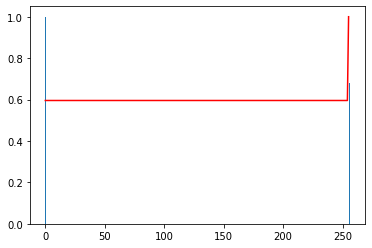

In [16]:
hist, bins = np.histogram(Mask_cell, bins=256, range=[0,256])
cum_hist = np.cumsum(hist)

height, width = Mask_cell.shape
norm_cum_hist = cum_hist / (height * width)
norm_hist = hist / hist.max()

#width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, norm_hist, align='center')
plt.plot(norm_cum_hist, color='r')
plt.show()

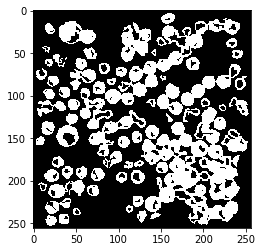

In [21]:
M_cyto = 'Tcells_Th0_1n_photons_cyto.tiff'
Mask_cyto = imageio.imread(os.path.join(Mask_dir,M_cyto))
# plt.imshow(Mask_cyto, cmap='gray', vmin=0, vmax=255)
# print(Mask_cyto.shape)

Mask_cyto[Mask_cyto>=1] = 1
plt.imshow(Mask_cyto, cmap='gray', vmin=0, vmax=1)

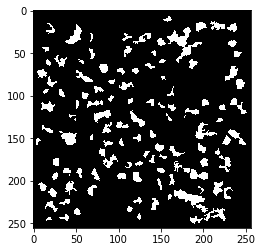

In [20]:
M_nuclei = 'Tcells_Th0_1n_photons_nuclei.tiff'
Mask_nuclei = imageio.imread(os.path.join(Mask_dir,M_nuclei))
# plt.imshow(Mask_nuclei, cmap='gray', vmin=0, vmax=255)
# print(Mask_nuclei.shape)

Mask_nuclei[Mask_nuclei>=1] = 1
plt.imshow(Mask_nuclei, cmap='gray', vmin=0, vmax=1)

In [ ]:
image_list, label_list = read_data(image_dir, label_dir)
X_train, X_test, y_train, y_test = create_training_dataset(image_list, label_list)
model = train_model(X_train, y_train, classifier)
test_model(X_test, y_test, model)